# **ConvFinQA**

# **The metric that I will use to evaluate the model will be**

##  'Program Equivalence': This is the reasoning program the model will be used to determine the final answer. . 

---

## Rationale: Focused on primarily the correctness of (i) does the model choose the correct program e.g. divide(7, 14), add(#0,7).The model will have some freedom to choose how to conduct this, but the focus will be on ensuring that it will fundamentally be the same calculation. As such, if the model is able to create the correct program and execute it, it can be assumed it will arrive at the correct answer.


---

### Step-by-Step Workflow 
- 1. Run experiment via 'process_records' - LLM Model is evaluating 
- 2. Eval at row level - 
- 3. Eval at group aggregrate level via the 'exact_match_score'
- 4. LLM as judge to understand ways errors are being made and can gather info for prompt improvements

# 1. Load Data & Import Packages

In [ ]:
from openai import OpenAI
import json
import os
import re
import random
import pandas as pd
from src.paths import DATA_DIR
from src.models import gpt_4o, gpt_4o_mini, preview_o1

# Ensure dataframe has max with
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Load the API key from environment variables
api_key = os.getenv("OPENAI_API_KEY")
openai = OpenAI(api_key=api_key)

# Training original data
with open(DATA_DIR / "train.json") as file:
    train_orig = json.load(file)

# 2. Load filtered data 

- "pre_text": the texts before the table;

- "post_text": the text after the table;

- "table": the table;

- "id": unique example id. composed by the original report name plus example
index for this report.

- "qa": {
  - "question": the question;

  - "program": the reasoning program;

  - "gold_inds": the gold supporting facts;

  - "exe_ans": the gold execution result;

  - "program_re": the reasoning program in nested format;
}

In [8]:
import os
import json
folder_path = "filtered_data/"
json_file_path = os.path.join(folder_path, "data.json")

with open(json_file_path, "r", encoding="utf-8") as f:
    train_filtered = json.load(f)


# train_filtered

In [10]:
print("Total records:", len(train_filtered))
print(type(train_filtered))

# get a list of all id's
all_ids = []
for i in range(len(train_filtered)):
  all_ids.append(train_filtered[i]['id'])

# all_ids
num_total = len(all_ids)
num_unique = len(set(all_ids))

# Check they are all unique and therefore make it easy to split
print(num_total)
print(num_unique)

Total records: 2082
<class 'list'>
2082
2082


# 3. Train(5%) / Dev (5%) / Test(5%) Split 

In [11]:
import random

# Ensure reproducibility
random.seed(42)  
random.shuffle(train_filtered)

# Total number of records
n = len(train_filtered)

# Correct percentages
train_end = int(0.10 * n)  # First 5% for train
dev_end   = train_end + int(0.10 * n)  # Next 5% for dev (so 10% total is used)
test_end   = dev_end+ int(0.10 * n)  # Next 5% for test (so 15 % total is used)

# Assign data splits
train_data = train_filtered[:train_end]  # First 5%
dev_data   = train_filtered[train_end:dev_end]  # Next 5%
test_data  = train_filtered[dev_end: test_end]  # Next 5%

# Print results
print("TRAIN records:", len(train_data))  
print("DEV records:",   len(dev_data))  
print("TEST records:",  len(test_data))  

# Check data types
print(type(train_data))  # Should be a list
print(type(train_data[0]))  # Should be a dict or whatever your dataset entries are

TRAIN records: 208
DEV records: 208
TEST records: 208
<class 'list'>
<class 'dict'>


In [13]:
# train_data


# 4. Experiment 1: Gpt-4o Basic Prompting Run & Evaluate program equivalence using LLM 

# Result: Program Equivalence Score:  79/208 (37.98%)

In [ ]:
len(train_data)
# llm_exp_train_df_copy = llm_exp_train_df.copy()
# llm_exp_train_df[ "program_equivalence"]
# llm_exp_train_df_copy[ "program_equivalence"]

# llm_exp_train_df.drop(['prgram_equivalence'], axis =1,  inplace=True)

# Boolean indexing approach
# llm_exp_train_df[llm_exp_train_df['id'] == 'Single_MO/2017/page_79.pdf-1']

208

In [92]:
from src.program_prompt.basic import V1_PROGRAM_SYSTEM_PROMPT
from src.llm import openai_llm
from src.models import gpt_4o, gpt_4o_mini
from src.preprocess import process_records, add_llm_explanation_column


# 1. 'process_records' creates the dataframe and columns 
train_df = process_records(
    records=train_data,
    system_prompts= V1_PROGRAM_SYSTEM_PROMPT,
    model_name=gpt_4o,
    prompt_style="Basic",
    table_key="html_table",   # or "html_table"
    model_pred_col_name="model_program_prediction" # new column being added from model predictions 
)

train_df[['program','model_program_prediction']].head(10)

,program,model_program_prediction
0,"multiply(10705, 178.84), divide(#0, const_1000000)","multiply(10705, 178.84), divide(#0, 1000000)"
1,"add(947, 6865), divide(6865, #0)","add(947, 6865), divide(6865, #0)"
2,"add(92, 116), add(#0, 118), divide(#1, const_3)","add(92, 116), add(#0, 118), divide(#0, 3)"
3,"add(60.68, 63.25), add(#0, 54.59), divide(#1, const_3)","add(60.68, 63.25), add(#0, 54.59), divide(#0, 3)"
4,"subtract(160468, 163607), divide(#0, 163607)","subtract(160468, 163607), divide(#0, 163607), multiply(#1, 100)"
5,"subtract(195.80, 100), divide(#0, 100), multiply(#1, const_1)","divide(195.80, 100.00)"
6,"subtract(108.38, 100), divide(#0, 100)","subtract(108.38, 100.00), divide(#0, 100.00)"
7,"add(4.5, 4.1), add(#0, 3.4)","add(4.5, 4.1), add(#0, 3.4)"
8,"add(92, 4), add(#0, 1), add(#1, 3)","add(92, 4), add(#0, 1), add(#0, 3)"
9,"add(87, 165), subtract(#0, 44)","add(87, 165), add(#0, -44)"


In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from src.program_prompt.model_eval import PROGRAM_EVALUATION_PROMPT


train_df = add_llm_explanation_column(
    df=train_df,
    system_prompts_dict=PROGRAM_EVALUATION_PROMPT,
    model_name=gpt_4o_mini,
    gold_col="program",
    pred_col="model_program_prediction",
    new_col_name="program_equivalence",
    table = "html_table"
)

train_df.head(5)

,id,question,gold_answer,clean_gold_answer,program,table,html_table,model,prompt_style,prompt,model_program_prediction,program_equivalence
0,Single_RE/2015/page_148.pdf-1,"what is the total value of granted shares of everest re during 2015 , in millions?",1.9,1.9,"multiply(10705, 178.84), divide(#0, const_1000000)","[[performance share unit awards, year ended december 31 2015 shares, year ended december 31 2015 weighted- average grant date fair value], [outstanding at january 1,, -, $ -], [granted, 10705, 178.84], [vested, -, -], [forfeited, -, -], [outstanding at december 31,, 10705, 178.84]]","<table>\n <thead>\n <tr>\n <th>performance share unit awards</th>\n <th>year ended december 31 2015 shares</th>\n <th>year ended december 31 2015 weighted- average grant date fair value</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>outstanding at january 1,</td><td>-</td><td>$ -</td></tr>\n <tr><td>granted</td><td>10705</td><td>178.84</td></tr>\n <tr><td>vested</td><td>-</td><td>-</td></tr>\n <tr><td>forfeited</td><td>-</td><td>-</td></tr>\n <tr><td>outstanding at december 31,</td><td>10705</td><td>178.84</td></tr>\n </tbody>\n</table>",gpt-4o,Basic,"{'system_prompt': 'You are a financial expert who can parse simple calculator-like programs. Each program is in the form: functionName(arg1, arg2), Examples are below hereprogram': 'subtract(137582, 143746), divide(#0, 143746) program': 'add(794, 717), add(#0, 645) with optional references such as #0 (the previous result), and constants or numeric values. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} Your task: - Produce ONLY the final program or series of functions, including complete function names. - You may use #0 if referencing a previous operation. - Do NOT provide explanations—just the program. '}","multiply(10705, 178.84), divide(#0, 1000000)",1
1,Single_AMT/2010/page_41.pdf-2,what portion of the new sites acquired or constructed during 2010 is located outside united states?,87.9%,87.9,"add(947, 6865), divide(6865, #0)","[[new sites ( acquired or constructed ), 2010, 2009, 2008], [domestic, 947, 528, 160], [international ( 1 ), 6865, 3022, 801]]",<table>\n <thead>\n <tr>\n <th>new sites ( acquired or constructed )</th>\n <th>2010</th>\n <th>2009</th>\n <th>2008</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>domestic</td><td>947</td><td>528</td><td>160</td></tr>\n <tr><td>international ( 1 )</td><td>6865</td><td>3022</td><td>801</td></tr>\n </tbody>\n</table>,gpt-4o,Basic,"{'system_prompt': 'You are a financial expert who can parse simple calculator-like programs. Each program is in the form: functionName(arg1, arg2), Examples are below hereprogram': 'subtract(137582, 143746), divide(#0, 143746) program': 'add(794, 717), add(#0, 645) with optional references such as #0 (the previous result), and constants or numeric values. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} Your task: - Produce ONLY the final program or series of functions, including complete function names. - You may use #0 if referencing a previous operation. - Do NOT provide explanations—just the program. '}","add(947, 6865), divide(6865, #0)",1
2,Single_UNP/2008/page_34.pdf-2,what was the average other income,108.7,108.7,"add(92, 116), add(#0, 118), divide(#1, const_3)","[[millions of dollars, 2008, 2007, 2006, % ( % ) change 2008 v 2007, % ( % ) change 2007 v 2006], [other income, $ 92, $ 116, $ 118, ( 21 ) % ( % ), ( 2 ) % ( % )], [interest expense, -511 ( 511 ), -482 ( 482 ), -477 ( 477 ), 6, 1], [income taxes, -1318 ( 1318 ), -1154 ( 1154 ), -919 ( 919 ), 14 % ( % ), 26 % ( % )]]",<table>\n <thead>\n <tr>\n <th>millions of dollars</th>\n <th>2008</th>\n <th>2007</th>\n <th>2006</th>\n <th>% ( % ) change 2008 v 2007</th>\n <th>% ( % ) change 2007 v 2006</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>other income</td><td>$ 92</td><td>$ 116</td><td>$ 118</td><td>( 21 ) % ( % )</td><td>( 2 ) % ( % )</td></tr>\n <tr><td>interest expense</td><td>-511

In [ ]:
# 3. Eval at aggreate level to see performance
from src.evals import exact_match_score_numeric
print(exact_match_score_numeric(train_df , "program_equivalence"))
train_df.head(2)

Accuracy Score: 79/208 (37.98%)


,id,question,gold_answer,clean_gold_answer,program,table,html_table,model,prompt_style,prompt,model_program_prediction,program_equivalence
0,Single_RE/2015/page_148.pdf-1,"what is the total value of granted shares of everest re during 2015 , in millions?",1.9,1.9,"multiply(10705, 178.84), divide(#0, const_1000000)","[[performance share unit awards, year ended december 31 2015 shares, year ended december 31 2015 weighted- average grant date fair value], [outstanding at january 1,, -, $ -], [granted, 10705, 178.84], [vested, -, -], [forfeited, -, -], [outstanding at december 31,, 10705, 178.84]]","<table>\n <thead>\n <tr>\n <th>performance share unit awards</th>\n <th>year ended december 31 2015 shares</th>\n <th>year ended december 31 2015 weighted- average grant date fair value</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>outstanding at january 1,</td><td>-</td><td>$ -</td></tr>\n <tr><td>granted</td><td>10705</td><td>178.84</td></tr>\n <tr><td>vested</td><td>-</td><td>-</td></tr>\n <tr><td>forfeited</td><td>-</td><td>-</td></tr>\n <tr><td>outstanding at december 31,</td><td>10705</td><td>178.84</td></tr>\n </tbody>\n</table>",gpt-4o,Basic,"{'system_prompt': 'You are a financial expert who can parse simple calculator-like programs. Each program is in the form: functionName(arg1, arg2), Examples are below hereprogram': 'subtract(137582, 143746), divide(#0, 143746) program': 'add(794, 717), add(#0, 645) with optional references such as #0 (the previous result), and constants or numeric values. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} Your task: - Produce ONLY the final program or series of functions, including complete function names. - You may use #0 if referencing a previous operation. - Do NOT provide explanations—just the program. '}","multiply(10705, 178.84), divide(#0, 1000000)",1
1,Single_AMT/2010/page_41.pdf-2,what portion of the new sites acquired or constructed during 2010 is located outside united states?,87.9%,87.9,"add(947, 6865), divide(6865, #0)","[[new sites ( acquired or constructed ), 2010, 2009, 2008], [domestic, 947, 528, 160], [international ( 1 ), 6865, 3022, 801]]",<table>\n <thead>\n <tr>\n <th>new sites ( acquired or constructed )</th>\n <th>2010</th>\n <th>2009</th>\n <th>2008</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>domestic</td><td>947</td><td>528</td><td>160</td></tr>\n <tr><td>international ( 1 )</td><td>6865</td><td>3022</td><td>801</td></tr>\n </tbody>\n</table>,gpt-4o,Basic,"{'system_prompt': 'You are a financial expert who can parse simple calculator-like programs. Each program is in the form: functionName(arg1, arg2), Examples are below hereprogram': 'subtract(137582, 143746), divide(#0, 143746) program': 'add(794, 717), add(#0, 645) with optional references such as #0 (the previous result), and constants or numeric values. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} Your task: - Produce ONLY the final program or series of functions, including complete function names. - You may use #0 if referencing a previous operation. - Do NOT provide explanations—just the program. '}","add(947, 6865), divide(6865, #0)",1


# 4.1 Analysing Errors:

In [121]:
# Lets only look at false 
train_df_false_only = train_df[train_df["program_equivalence"] == 0]
len(train_df_false_only)
train_df_false_only.head(2)
                                                      

,id,question,gold_answer,clean_gold_answer,program,table,html_table,model,prompt_style,prompt,model_program_prediction,program_equivalence
2,Single_UNP/2008/page_34.pdf-2,what was the average other income,108.7,108.7,"add(92, 116), add(#0, 118), divide(#1, const_3)","[[millions of dollars, 2008, 2007, 2006, % ( % ) change 2008 v 2007, % ( % ) change 2007 v 2006], [other income, $ 92, $ 116, $ 118, ( 21 ) % ( % ), ( 2 ) % ( % )], [interest expense, -511 ( 511 ), -482 ( 482 ), -477 ( 477 ), 6, 1], [income taxes, -1318 ( 1318 ), -1154 ( 1154 ), -919 ( 919 ), 14 % ( % ), 26 % ( % )]]",<table>\n <thead>\n <tr>\n <th>millions of dollars</th>\n <th>2008</th>\n <th>2007</th>\n <th>2006</th>\n <th>% ( % ) change 2008 v 2007</th>\n <th>% ( % ) change 2007 v 2006</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>other income</td><td>$ 92</td><td>$ 116</td><td>$ 118</td><td>( 21 ) % ( % )</td><td>( 2 ) % ( % )</td></tr>\n <tr><td>interest expense</td><td>-511 ( 511 )</td><td>-482 ( 482 )</td><td>-477 ( 477 )</td><td>6</td><td>1</td></tr>\n <tr><td>income taxes</td><td>-1318 ( 1318 )</td><td>-1154 ( 1154 )</td><td>-919 ( 919 )</td><td>14 % ( % )</td><td>26 % ( % )</td></tr>\n </tbody>\n</table>,gpt-4o,Basic,"{'system_prompt': 'You are a financial expert who can parse simple calculator-like programs. Each program is in the form: functionName(arg1, arg2), Examples are below hereprogram': 'subtract(137582, 143746), divide(#0, 143746) program': 'add(794, 717), add(#0, 645) with optional references such as #0 (the previous result), and constants or numeric values. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} Your task: - Produce ONLY the final program or series of functions, including complete function names. - You may use #0 if referencing a previous operation. - Do NOT provide explanations—just the program. '}","add(92, 116), add(#0, 118), divide(#0, 3)",0
3,Single_PNC/2012/page_222.pdf-3,"what was the average cost per unit for the weighted-average grant-date fair value of incentive/ performance unit share awards and restricted stock/unit awards granted in 2012 , 2011 and 2010?",59.5,59.5,"add(60.68, 63.25), add(#0, 54.59), divide(#1, const_3)","[[shares in thousands december 31 2011, nonvested incentive/ performance unit shares 830, weighted-averagegrantdate fairvalue $ 61.68, nonvested restricted stock/ unit shares 2512, weighted-averagegrantdate fairvalue $ 54.87], [granted, 465, 60.70, 1534, 60.67], [vested, -100 ( 100 ), 64.21, -831 ( 831 ), 45.47], [forfeited, -76 ( 76 ), 60.27, -154 ( 154 ), 60.51], [december 31 2012, 1119, $ 61.14, 3061, $ 60.04]]",<table>\n <thead>\n <tr>\n <th>shares in thousands december 31 2011</th>\n <th>nonvested incentive/ performance unit shares 830</th>\n <th>weighted-averagegrantdate fairvalue $ 61.68</th>\n <th>nonvested restricted stock/ unit shares 2512</th>\n <th>weighted-averagegrantdate fairvalue $ 54.87</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>granted</td><td>465</td><td>60.70</td><td>1534</td><td>60.67</td></tr>\n <tr><td>vested</td><td>-100 ( 100 )</td><td>64.21</td><td>-831 ( 831 )</td><td>45.47</td></tr>\n <tr><td>forfeited</td><td>-76 ( 76 )</td><td>60.27</td><td>-154 ( 154 )</td><td>60.51</td></tr>\n <tr><td>december 31 2012</td><td>1119</td><td>$ 61.14</td><td>3061</td><td>$ 60.04</td></tr>\n </tbody>\n</table>,gpt-4o,Basic,"{'system_prompt': 'You are a financial expert who can parse simple calculator-like programs. Each program is in the form: functionName(arg1, arg2), Examples are below hereprogram': 'subtract(137582, 143746), divide(#0, 143746) program': 'add(794, 717), add(#0, 645) with optional references such as #0 (the previous result), and constants or numeric values. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} Your task: - Produce ONLY the final program or series of functions, including complete function names. - You may use #0 if referencing a previous operation. - Do NOT provide explanations—just the progra

In [ ]:
# llm_exp_train_df.drop('answer_reasoning', axis=1, inplace=True)

# 4.2 Only looking at 100 of those that were wrong for cost and time considerations

In [141]:
from src.LLM_as_judge.program import V1_EXPLANATION_PROGRAM_PROMPT 

llm_exp_train_df = add_llm_explanation_column(
    df=train_df_false_only[:100],
    system_prompts_dict=V1_EXPLANATION_PROGRAM_PROMPT ,
    model_name=gpt_4o,
    gold_col="program",
    pred_col="model_program_prediction",
    new_col_name="program_reasoning",
    table = "html_table"
)

llm_exp_train_df.head(5)

,id,question,gold_answer,clean_gold_answer,program,table,html_table,model,prompt_style,prompt,model_program_prediction,program_equivalence,program_reasoning
2,Single_UNP/2008/page_34.pdf-2,what was the average other income,108.7,108.70,"add(92, 116), add(#0, 118), divide(#1, const_3)","[[millions of dollars, 2008, 2007, 2006, % ( % ) change 2008 v 2007, % ( % ) change 2007 v 2006], [other income, $ 92, $ 116, $ 118, ( 21 ) % ( % ), ( 2 ) % ( % )], [interest expense, -511 ( 511 ), -482 ( 482 ), -477 ( 477 ), 6, 1], [income taxes, -1318 ( 1318 ), -1154 ( 1154 ), -919 ( 919 ), 14 % ( % ), 26 % ( % )]]",<table>\n <thead>\n <tr>\n <th>millions of dollars</th>\n <th>2008</th>\n <th>2007</th>\n <th>2006</th>\n <th>% ( % ) change 2008 v 2007</th>\n <th>% ( % ) change 2007 v 2006</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>other income</td><td>$ 92</td><td>$ 116</td><td>$ 118</td><td>( 21 ) % ( % )</td><td>( 2 ) % ( % )</td></tr>\n <tr><td>interest expense</td><td>-511 ( 511 )</td><td>-482 ( 482 )</td><td>-477 ( 477 )</td><td>6</td><td>1</td></tr>\n <tr><td>income taxes</td><td>-1318 ( 1318 )</td><td>-1154 ( 1154 )</td><td>-919 ( 919 )</td><td>14 % ( % )</td><td>26 % ( % )</td></tr>\n </tbody>\n</table>,gpt-4o,Basic,"{'system_prompt': 'You are a financial expert who can parse simple calculator-like programs. Each program is in the form: functionName(arg1, arg2), Examples are below hereprogram': 'subtract(137582, 143746), divide(#0, 143746) program': 'add(794, 717), add(#0, 645) with optional references such as #0 (the previous result), and constants or numeric values. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} Your task: - Produce ONLY the final program or series of functions, including complete function names. - You may use #0 if referencing a previous operation. - Do NOT provide explanations—just the program. '}","add(92, 116), add(#0, 118), divide(#0, 3)",0,"Upon analyzing the programs, we can observe the following:\n\n1. **Step 1**: Both programs start with the same operation:\n - `add(92, 116)`, which correctly adds 92 and 116 to yield 208.\n\n2. **Step 2**: Both programs perform the same addition operation next:\n - `add(#0, 118)` correctly utilizes the result from the first step (208) and adds 118, resulting in 326.\n\n3. **Step 3**: This is where the discrepancy occurs:\n - In the ground truth program, `divide(#1, const_3)` uses the result from Step 2 (326) and divides it by 3.\n - In the model-predicted program, `divide(#0, 3)` incorrectly uses the result from Step 1 (208) and divides it by 3.\n\n**Differences and Error Category**:\n- **Result source error**: The predicted program uses the wrong intermediate result for the division operation. It takes the result from Step 1 instead of Step 2, which directly impacts the final output.\n- **Operation context error**: Also, the model uses a fixed numerical division by `3`, similar to the ground truth conceptually, but applied to the incorrect reference (#0 instead of #1).\n\nAs a result, the programs will yield different outcomes due to the division operation in Step 3 being based on different inputs (326 vs. 208)."
3,Single_PNC/2012/page_222.pdf-3,"what was the average cost per unit for the weighted-average grant-date fair value of incentive/ performance unit share awards and restricted stock/unit awards granted in 2012 , 2011 and 2010?",59.5,59.50,"add(60.68, 63.25), add(#0, 54.59), divide(#1, const_3)","[[shares in thousands december 31 2011, nonvested incentive/ performance unit shares 830, weighted-averagegrantdate fairvalue $ 61.68, nonvested restricted stock/ unit shares 2512, weighted-averagegrantdate fairvalue $ 54.87], [granted, 465, 60.70, 1534, 60.67], [vested, -100 ( 100 ), 64.21, -831 ( 831 ), 45.47], [forfeited, -76 ( 76 ), 60.27, -154 ( 154 ), 60.51], [december 31 2012, 1119, $ 61.14, 3061, $ 60.04]]",<table>\n <thead>\n <tr>\n <th>shares in thousands december 31 2011</th>\n <th>nonvested incentive/ performance unit shares 

In [142]:
# llm_exp_train_df['program_reasoning'].to_list()

In [143]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
from src.LLM_as_judge.program import PROGRAM_ERROR_CATEGORIZATION_PROMPT

llm_exp_train_df= add_llm_explanation_column(
    df=llm_exp_train_df,
    system_prompts_dict=PROGRAM_ERROR_CATEGORIZATION_PROMPT,
    model_name=gpt_4o_mini,
    gold_col="program",
    pred_col="program_reasoning",
    new_col_name="program_error_category",
    table = "html_table"
)

llm_exp_train_df.head(5)

,id,question,gold_answer,clean_gold_answer,program,table,html_table,model,prompt_style,prompt,model_program_prediction,program_equivalence,program_reasoning,program_error_category
2,Single_UNP/2008/page_34.pdf-2,what was the average other income,108.7,108.70,"add(92, 116), add(#0, 118), divide(#1, const_3)","[[millions of dollars, 2008, 2007, 2006, % ( % ) change 2008 v 2007, % ( % ) change 2007 v 2006], [other income, $ 92, $ 116, $ 118, ( 21 ) % ( % ), ( 2 ) % ( % )], [interest expense, -511 ( 511 ), -482 ( 482 ), -477 ( 477 ), 6, 1], [income taxes, -1318 ( 1318 ), -1154 ( 1154 ), -919 ( 919 ), 14 % ( % ), 26 % ( % )]]",<table>\n <thead>\n <tr>\n <th>millions of dollars</th>\n <th>2008</th>\n <th>2007</th>\n <th>2006</th>\n <th>% ( % ) change 2008 v 2007</th>\n <th>% ( % ) change 2007 v 2006</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>other income</td><td>$ 92</td><td>$ 116</td><td>$ 118</td><td>( 21 ) % ( % )</td><td>( 2 ) % ( % )</td></tr>\n <tr><td>interest expense</td><td>-511 ( 511 )</td><td>-482 ( 482 )</td><td>-477 ( 477 )</td><td>6</td><td>1</td></tr>\n <tr><td>income taxes</td><td>-1318 ( 1318 )</td><td>-1154 ( 1154 )</td><td>-919 ( 919 )</td><td>14 % ( % )</td><td>26 % ( % )</td></tr>\n </tbody>\n</table>,gpt-4o,Basic,"{'system_prompt': 'You are a financial expert who can parse simple calculator-like programs. Each program is in the form: functionName(arg1, arg2), Examples are below hereprogram': 'subtract(137582, 143746), divide(#0, 143746) program': 'add(794, 717), add(#0, 645) with optional references such as #0 (the previous result), and constants or numeric values. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} Your task: - Produce ONLY the final program or series of functions, including complete function names. - You may use #0 if referencing a previous operation. - Do NOT provide explanations—just the program. '}","add(92, 116), add(#0, 118), divide(#0, 3)",0,"Upon analyzing the programs, we can observe the following:\n\n1. **Step 1**: Both programs start with the same operation:\n - `add(92, 116)`, which correctly adds 92 and 116 to yield 208.\n\n2. **Step 2**: Both programs perform the same addition operation next:\n - `add(#0, 118)` correctly utilizes the result from the first step (208) and adds 118, resulting in 326.\n\n3. **Step 3**: This is where the discrepancy occurs:\n - In the ground truth program, `divide(#1, const_3)` uses the result from Step 2 (326) and divides it by 3.\n - In the model-predicted program, `divide(#0, 3)` incorrectly uses the result from Step 1 (208) and divides it by 3.\n\n**Differences and Error Category**:\n- **Result source error**: The predicted program uses the wrong intermediate result for the division operation. It takes the result from Step 1 instead of Step 2, which directly impacts the final output.\n- **Operation context error**: Also, the model uses a fixed numerical division by `3`, similar to the ground truth conceptually, but applied to the incorrect reference (#0 instead of #1).\n\nAs a result, the programs will yield different outcomes due to the division operation in Step 3 being based on different inputs (326 vs. 208).",Variable Reference Error
3,Single_PNC/2012/page_222.pdf-3,"what was the average cost per unit for the weighted-average grant-date fair value of incentive/ performance unit share awards and restricted stock/unit awards granted in 2012 , 2011 and 2010?",59.5,59.50,"add(60.68, 63.25), add(#0, 54.59), divide(#1, const_3)","[[shares in thousands december 31 2011, nonvested incentive/ performance unit shares 830, weighted-averagegrantdate fairvalue $ 61.68, nonvested restricted stock/ unit shares 2512, weighted-averagegrantdate fairvalue $ 54.87], [granted, 465, 60.70, 1534, 60.67], [vested, -100 ( 100 ), 64.21, -831 ( 831 ), 45.47], [forfeited, -76 ( 76 ), 60.27, -154 ( 154 ), 60.51], [december 31 2012, 1119, $ 61.14, 3061, $ 60.04]]",<table>\n <thead>\n <tr>\n <th>shares in thousands december 31 2011</th>\n <

In [145]:
llm_exp_train_df['program_error_category'] = llm_exp_train_df['program_error_category'].astype('category')
print(llm_exp_train_df['program_error_category'].dtypes)

category


# 4.3 Error cateogory distribution

---

### - Missing or Extra Computation Steps -  The predicted program skips a necessary step** or adds an unnecessary operation: **63%**
---


### - Incorrect Mathematical Operation - The predicted program uses the wrong function (e.g., `divide()` instead of `subtract()`): **19%**
---


### - Variable Reference Error - The predicted program incorrectly references intermediate values (`#0`, `#1`): **10%**
---


### - Reordering Without Preserving Meaning - The predicted program changes the order of operations, altering the final result: **7%**
---

### - Misinterpretation of Constants -  The predicted program replaces `const_100`, `const_3`, etc., with hardcoded numbers: **1%**
---




    


program_error_category
Missing or Extra Computation Steps       63
Incorrect Mathematical Operation         19
Variable Reference Error                 10
Reordering Without Preserving Meaning     7
Misinterpretation of Constants            1
Name: count, dtype: int64


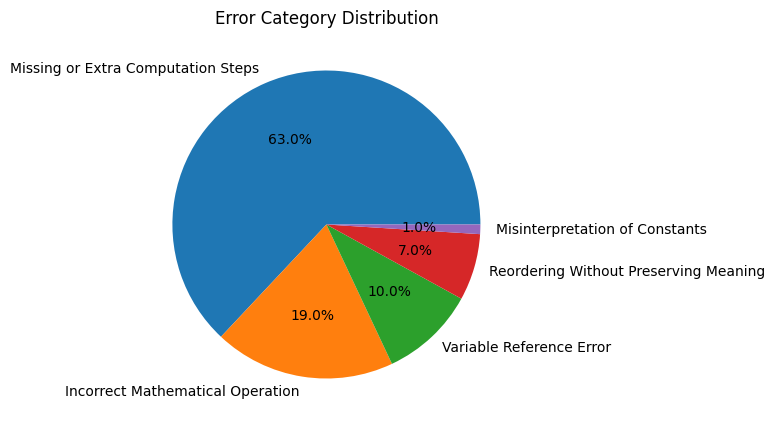

In [147]:
import pandas as pd
import matplotlib.pyplot as plt

# Suppose your DataFrame is named 'df'
# and has a column called 'answer_error_category'

# 1. Count per category
category_counts = llm_exp_train_df['program_error_category'].value_counts(dropna=False)
print(category_counts)



# 2. Pie chart
plt.figure(figsize=(5, 5))
category_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Error Category Distribution')
plt.ylabel('')  # hide the default label
plt.show()

# 5. Experiment 2: GPt-4o Few-shot Prompt using error categories to improve prompt: 
---

# Result: Program Equivalence Score: 44/208 (21.15%)


### - Quite a large drop in performance surprisingly compared to the previous prompt. Despite providing more info, clarity on the types of errors being made, its decreased the eval. 


In [ ]:
from src.program_prompt.few_shot import V1_PROGRAM_FEW_SHOT_PROMPT 


# 1. 'process_records' creates the dataframe and columns 
v2_prompt_train_df = process_records(
    records=train_data,
    system_prompts= V1_PROGRAM_FEW_SHOT_PROMPT,
    model_name=gpt_4o,
    prompt_style="Basic-Improved", # should say few-shot I forgot to change prior to run
    table_key="html_table",   # or "html_table"
    model_pred_col_name="model_program_prediction" # new column being added from model predictions 
)

v2_prompt_train_df [['program','model_program_prediction']].head(10)

,program,model_program_prediction
0,"multiply(10705, 178.84), divide(#0, const_1000000)","""multiply(10705, 178.84), divide(#0, const_1000000)"""
1,"add(947, 6865), divide(6865, #0)","""add(947, 6865), divide(6865, #0)"""
2,"add(92, 116), add(#0, 118), divide(#1, const_3)","""add(92, 116), add(#0, 118), divide(#1, 3)"""
3,"add(60.68, 63.25), add(#0, 54.59), divide(#1, const_3)","""add(60.68, 63.25), add(#0, 54.59), divide(#1, 3)"""
4,"subtract(160468, 163607), divide(#0, 163607)","""subtract(160468, 163607), divide(#0, 163607), multiply(#1, const_100)"""
5,"subtract(195.80, 100), divide(#0, 100), multiply(#1, const_1)","""subtract(195.80, 100.00), divide(#0, 100.00)"""
6,"subtract(108.38, 100), divide(#0, 100)","""subtract(108.38, 100.00), divide(#0, 100.00), multiply(#1, const_100)"""
7,"add(4.5, 4.1), add(#0, 3.4)","""add(4.5, 4.1), add(#0, 3.4)"""
8,"add(92, 4), add(#0, 1), add(#1, 3)","""add(92, 4), add(#0, 1), add(#1, 3)"""
9,"add(87, 165), subtract(#0, 44)","""add(87, 165), subtract(#0, 44)"""


In [154]:
from src.program_prompt.model_eval import PROGRAM_EVALUATION_PROMPT


v2_prompt_train_df  = add_llm_explanation_column(
    df= v2_prompt_train_df,
    system_prompts_dict=PROGRAM_EVALUATION_PROMPT,
    model_name=gpt_4o_mini,
    gold_col="program",
    pred_col="model_program_prediction",
    new_col_name="program_equivalence",
    table = "html_table"
)

v2_prompt_train_df.head(5)

id  \
0    Single_RE/2015/page_148.pdf-1   
1    Single_AMT/2010/page_41.pdf-2   
2    Single_UNP/2008/page_34.pdf-2   
3   Single_PNC/2012/page_222.pdf-3   
4  Single_ADBE/2012/page_102.pdf-2   

                                                                                                                                                                                          question  \
0                                                                                                               what is the total value of granted shares of everest re during 2015 , in millions?   
1                                                                                              what portion of the new sites acquired or constructed during 2010 is located outside united states?   
2                                                                                                                                                                what was the average other income   
3  what was the average cost per unit for the weighted-average grant-date fair value of incentive/ performance unit share awards and restricted stock/unit awards granted in 2012 , 2011 and 2010?   
4                                                                                              what is the percentage change in total gross amount of unrecognized tax benefits from 2011 to 2012?   

  gold_answer  clean_gold_answer  \
0         1.9                1.9   
1       87.9%               87.9   
2       108.7              108.7   
3        59.5               59.5   
4       -1.9%               -1.9   

                                                  program  \
0      multiply(10705, 178.84), divide(#0, const_1000000)   
1                        add(947, 6865), divide(6865, #0)   
2         add(92, 116), add(#0, 118), divide(#1, const_3)   
3  add(60.68, 63.25), add(#0, 54.59), divide(#1, const_3)   
4            subtract(160468, 163607), divide(#0, 163607)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         table  \
0                                                                                                                                                                                                                                                                                                                   [[performance share unit awards, year ended december 31 2015 shares, year ended december 31 2015 weighted- average grant date fair value], [outstanding at january 1,, -, $ -], [granted, 10705, 178.84], [vested, -, -], [forfeited, -, -], [outstanding at december 31,, 10705, 178.84]]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                               [[new sites ( acquired or constructed ), 2010, 2009, 2008], [domestic, 947, 528, 160], [international ( 1 ), 6865, 3022, 801]]   
2                                                                                                                                                                                                                                                       

In [ ]:
# 3. Eval at aggreate level to see performance
from src.evals import exact_match_score_numeric
print(exact_match_score_numeric(v2_prompt_train_df , "program_equivalence"))
v2_prompt_train_df.head(2)

Accuracy Score: 44/208 (21.15%)


,id,question,gold_answer,clean_gold_answer,program,table,html_table,model,prompt_style,prompt,model_program_prediction,program_equivalence
0,Single_RE/2015/page_148.pdf-1,"what is the total value of granted shares of everest re during 2015 , in millions?",1.9,1.9,"multiply(10705, 178.84), divide(#0, const_1000000)","[[performance share unit awards, year ended december 31 2015 shares, year ended december 31 2015 weighted- average grant date fair value], [outstanding at january 1,, -, $ -], [granted, 10705, 178.84], [vested, -, -], [forfeited, -, -], [outstanding at december 31,, 10705, 178.84]]","<table>\n <thead>\n <tr>\n <th>performance share unit awards</th>\n <th>year ended december 31 2015 shares</th>\n <th>year ended december 31 2015 weighted- average grant date fair value</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>outstanding at january 1,</td><td>-</td><td>$ -</td></tr>\n <tr><td>granted</td><td>10705</td><td>178.84</td></tr>\n <tr><td>vested</td><td>-</td><td>-</td></tr>\n <tr><td>forfeited</td><td>-</td><td>-</td></tr>\n <tr><td>outstanding at december 31,</td><td>10705</td><td>178.84</td></tr>\n </tbody>\n</table>",gpt-4o,Basic,"{'system_prompt': 'You are a financial expert who can parse simple calculator-like programs. Each program is in the form: functionName(arg1, arg2), Examples are below hereprogram': 'subtract(137582, 143746), divide(#0, 143746) program': 'add(794, 717), add(#0, 645) with optional references such as #0 (the previous result), and constants or numeric values. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} Your task: - Produce ONLY the final program or series of functions, including complete function names. - You may use #0 if referencing a previous operation. - Do NOT provide explanations—just the program. '}","multiply(10705, 178.84), divide(#0, 1000000)",1
1,Single_AMT/2010/page_41.pdf-2,what portion of the new sites acquired or constructed during 2010 is located outside united states?,87.9%,87.9,"add(947, 6865), divide(6865, #0)","[[new sites ( acquired or constructed ), 2010, 2009, 2008], [domestic, 947, 528, 160], [international ( 1 ), 6865, 3022, 801]]",<table>\n <thead>\n <tr>\n <th>new sites ( acquired or constructed )</th>\n <th>2010</th>\n <th>2009</th>\n <th>2008</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>domestic</td><td>947</td><td>528</td><td>160</td></tr>\n <tr><td>international ( 1 )</td><td>6865</td><td>3022</td><td>801</td></tr>\n </tbody>\n</table>,gpt-4o,Basic,"{'system_prompt': 'You are a financial expert who can parse simple calculator-like programs. Each program is in the form: functionName(arg1, arg2), Examples are below hereprogram': 'subtract(137582, 143746), divide(#0, 143746) program': 'add(794, 717), add(#0, 645) with optional references such as #0 (the previous result), and constants or numeric values. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} Your task: - Produce ONLY the final program or series of functions, including complete function names. - You may use #0 if referencing a previous operation. - Do NOT provide explanations—just the program. '}","add(947, 6865), divide(6865, #0)",1


id  \
0  Single_RE/2015/page_148.pdf-1   
1  Single_AMT/2010/page_41.pdf-2   

                                                                                              question  \
0                   what is the total value of granted shares of everest re during 2015 , in millions?   
1  what portion of the new sites acquired or constructed during 2010 is located outside united states?   

  gold_answer  clean_gold_answer  \
0         1.9                1.9   
1       87.9%               87.9   

                                              program  \
0  multiply(10705, 178.84), divide(#0, const_1000000)   
1                    add(947, 6865), divide(6865, #0)   

                                                                                                                                                                                                                                                                                        table  \
0  [[performance share unit awards, year ended december 31 2015 shares, year ended december 31 2015 weighted- average grant date fair value], [outstanding at january 1,, -, $ -], [granted, 10705, 178.84], [vested, -, -], [forfeited, -, -], [outstanding at december 31,, 10705, 178.84]]   
1                                                                                                                                                              [[new sites ( acquired or constructed ), 2010, 2009, 2008], [domestic, 947, 528, 160], [international ( 1 ), 6865, 3022, 801]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            html_table  \
0  <table>\n  <thead>\n    <tr>\n      <th>performance share unit awards</th>\n      <th>year ended december 31 2015 shares</th>\n      <th>year ended december 31 2015 weighted- average grant date fair value</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr><td>outstanding at january 1,</td><td>-</td><td>$ -</td></tr>\n    <tr><td>granted</td><td>10705</td><td>178.84</td></tr>\n    <tr><td>vested</td><td>-</td><td>-</td></tr>\n    <tr><td>forfeited</td><td>-</td><td>-</td></tr>\n    <tr><td>outstanding at december 31,</td><td>10705</td><td>178.84</td></tr>\n  </tbody>\n</table>   
1                                                                                                                                                                                                                                       <table>\n  <thead>\n    <tr>\n      <th>new sites ( acquired or constructed )</th>\n      <th>2010</th>\n      <th>2009</th>\n      <th>2008</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr><td>domestic</td><td>947</td><td>528</td><td>160</td></tr>\n    <tr><td>international ( 1 )</td><td>6865</td><td>3022</td><td>801</td></tr>\n  </tbody>\n</table>   

    model    prompt_style  \
0  gpt-4o  Basic-Improved   
1  gpt-4o  Basic-Improved   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

# 6. Experiment 3: Cot ... **to-do**

# Result: 


In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from src.program_prompt.few_shot import V1_PROGRAM_FEW_SHOT_PROMPT 

# 1. 'process_records' creates the dataframe and columns 
few_shot_train_df = process_records(
    records=train_data,
    system_prompts= V1_PROGRAM_FEW_SHOT_PROMPT,
    model_name=gpt_4o,
    prompt_style="Few-shot",
    table_key="html_table",   # or "html_table"
    model_pred_col_name="model_program_prediction" # new column being added from model predictions 
)

few_shot_train_df[['program','model_program_prediction']].head(10)

,program,model_program_prediction
0,"multiply(10705, 178.84), divide(#0, const_1000000)","""program"": ""multiply(10705, 178.84), divide(#0, const_1000000)"""
1,"add(947, 6865), divide(6865, #0)","""program"": ""add(947, 6865), divide(6865, #0), multiply(#1, const_100)"""
2,"add(92, 116), add(#0, 118), divide(#1, const_3)","""program"": ""add(92, 116), add(#0, 118), divide(#1, const_3)"""
3,"add(60.68, 63.25), add(#0, 54.59), divide(#1, const_3)","""program"": ""add(60.68, 63.25), add(#0, 54.59), divide(#1, const_3)"""
4,"subtract(160468, 163607), divide(#0, 163607)","""program"": ""subtract(160468, 163607), divide(#0, 163607), multiply(#1, const_100)"""
5,"subtract(195.80, 100), divide(#0, 100), multiply(#1, const_1)","""program"": ""subtract(195.80, 100), divide(#0, 100), add(#1, const_1)"""
6,"subtract(108.38, 100), divide(#0, 100)","""program"": ""subtract(108.38, 100.00), divide(#0, 100.00), multiply(#1, const_100)"""
7,"add(4.5, 4.1), add(#0, 3.4)","""program"": ""add(4.5, 4.1), add(#0, 3.4)"""
8,"add(92, 4), add(#0, 1), add(#1, 3)","""program"": ""add(92, 4), add(#0, 1), add(#1, 3)"""
9,"add(87, 165), subtract(#0, 44)","""program"": ""add(87, 165), add(#0, -44)"""


In [107]:
few_shot_train_df = add_llm_explanation_column(
    df=few_shot_train_df,
    system_prompts_dict= PROGRAM_EVALUATION_PROMPT,
    model_name=gpt_4o,
    gold_col="program",
    pred_col="model_program_prediction",
    new_col_name="program_equivalence",
    table = "html_table"
)

few_shot_train_df.head(5)

id  \
0    Single_RE/2015/page_148.pdf-1   
1    Single_AMT/2010/page_41.pdf-2   
2    Single_UNP/2008/page_34.pdf-2   
3   Single_PNC/2012/page_222.pdf-3   
4  Single_ADBE/2012/page_102.pdf-2   

                                                                                                                                                                                          question  \
0                                                                                                               what is the total value of granted shares of everest re during 2015 , in millions?   
1                                                                                              what portion of the new sites acquired or constructed during 2010 is located outside united states?   
2                                                                                                                                                                what was the average other income   
3  what was the average cost per unit for the weighted-average grant-date fair value of incentive/ performance unit share awards and restricted stock/unit awards granted in 2012 , 2011 and 2010?   
4                                                                                              what is the percentage change in total gross amount of unrecognized tax benefits from 2011 to 2012?   

  gold_answer  clean_gold_answer  \
0         1.9                1.9   
1       87.9%               87.9   
2       108.7              108.7   
3        59.5               59.5   
4       -1.9%               -1.9   

                                                  program  \
0      multiply(10705, 178.84), divide(#0, const_1000000)   
1                        add(947, 6865), divide(6865, #0)   
2         add(92, 116), add(#0, 118), divide(#1, const_3)   
3  add(60.68, 63.25), add(#0, 54.59), divide(#1, const_3)   
4            subtract(160468, 163607), divide(#0, 163607)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         table  \
0                                                                                                                                                                                                                                                                                                                   [[performance share unit awards, year ended december 31 2015 shares, year ended december 31 2015 weighted- average grant date fair value], [outstanding at january 1,, -, $ -], [granted, 10705, 178.84], [vested, -, -], [forfeited, -, -], [outstanding at december 31,, 10705, 178.84]]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                               [[new sites ( acquired or constructed ), 2010, 2009, 2008], [domestic, 947, 528, 160], [international ( 1 ), 6865, 3022, 801]]   
2                                                                                                                                                                                                                                                       

In [109]:
# 3. Eval at aggreate level to see performance
from src.evals import exact_match_score_numeric
print( exact_match_score_numeric(few_shot_train_df , "program_equivalence"))
few_shot_train_df.head(2)

Accuracy Score: 32.0/207 (15.46%)


id  \
0  Single_RE/2015/page_148.pdf-1   
1  Single_AMT/2010/page_41.pdf-2   

                                                                                              question  \
0                   what is the total value of granted shares of everest re during 2015 , in millions?   
1  what portion of the new sites acquired or constructed during 2010 is located outside united states?   

  gold_answer  clean_gold_answer  \
0         1.9                1.9   
1       87.9%               87.9   

                                              program  \
0  multiply(10705, 178.84), divide(#0, const_1000000)   
1                    add(947, 6865), divide(6865, #0)   

                                                                                                                                                                                                                                                                                        table  \
0  [[performance share unit awards, year ended december 31 2015 shares, year ended december 31 2015 weighted- average grant date fair value], [outstanding at january 1,, -, $ -], [granted, 10705, 178.84], [vested, -, -], [forfeited, -, -], [outstanding at december 31,, 10705, 178.84]]   
1                                                                                                                                                              [[new sites ( acquired or constructed ), 2010, 2009, 2008], [domestic, 947, 528, 160], [international ( 1 ), 6865, 3022, 801]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            html_table  \
0  <table>\n  <thead>\n    <tr>\n      <th>performance share unit awards</th>\n      <th>year ended december 31 2015 shares</th>\n      <th>year ended december 31 2015 weighted- average grant date fair value</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr><td>outstanding at january 1,</td><td>-</td><td>$ -</td></tr>\n    <tr><td>granted</td><td>10705</td><td>178.84</td></tr>\n    <tr><td>vested</td><td>-</td><td>-</td></tr>\n    <tr><td>forfeited</td><td>-</td><td>-</td></tr>\n    <tr><td>outstanding at december 31,</td><td>10705</td><td>178.84</td></tr>\n  </tbody>\n</table>   
1                                                                                                                                                                                                                                       <table>\n  <thead>\n    <tr>\n      <th>new sites ( acquired or constructed )</th>\n      <th>2010</th>\n      <th>2009</th>\n      <th>2008</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr><td>domestic</td><td>947</td><td>528</td><td>160</td></tr>\n    <tr><td>international ( 1 )</td><td>6865</td><td>3022</td><td>801</td></tr>\n  </tbody>\n</table>   

    model prompt_style  \
0  gpt-4o     Few-shot   
1  gpt-4o     Few-shot   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

# 7. Dev set testing - I'm not able to get the model to perform well enough on the train set to start testing on dev. 

- Once I get training set to perform better I would, then start testin against dev, make futher adaptations based on error analysis, perhaps different pre-processing and other prompt engineering techniques. 
- Once the llm is performing well on the dev set I would finally test on test set 

In [ ]:
# 1. 'process_records' creates the dataframe and columns 
dev_df = process_records(
    records=dev_data,
    system_prompts=x , # Best Prompt 
    model_name=gpt_4o,
    prompt_style="xxx",
    table_key="html_table",   # or "html_table"
    model_pred_col_name="model_program_prediction" # new column being added from model predictions 
)

dev_df[['program','model_program_prediction']].head(10)

In [ ]:
from src.program_prompt.model_eval import PROGRAM_EVALUATION_PROMPT


dev_df = add_llm_explanation_column(
    df= dev_df,
    system_prompts_dict=PROGRAM_EVALUATION_PROMPT,
    model_name=gpt_4o_mini,
    gold_col="program",
    pred_col="model_program_prediction",
    new_col_name="program_equivalence",
    table = "html_table"
)

dev_df.head(5)

In [ ]:
# 3. Eval at aggreate level to see performance
from src.evals import exact_match_score_numeric
print(exact_match_score_numeric(dev_data , "program_equivalence"))
dev_data.head(2)

# 8. Results and Insights 

# - Basic Prompting: 79/208 (37.98%)

# - Few-shot Prompt: 44/208 (21.15%)


## Insights 

- The initial prompt and setup seemed to show some promise and after looking at the errors and cateogorising them and using this information within the prompt, it would have been reasonable to expext the model to perform better.

## Error cateogory distribution

- Missing or Extra Computation Steps -   **63%**

- Incorrect Mathematical Operation - **19%**

- Variable Reference Error -**10%**

- Reordering Without Preserving Meaning - **7%**

- Misinterpretation of Constants - **1%**

## Recommendations 

- Utilising a reasoning model
- further Prompt optimization
- Fine tuning 

# Save data 

In [ ]:
# data_folder_path = "program_data/"
# os.makedirs(data_folder_path, exist_ok=True)


In [ ]:
# file_path = os.path.join(data_folder_path,'train_df_program.csv')
# train_df.to_csv(file_path, index = False)

In [ ]:
# file_path = os.path.join(data_folder_path,'llm_exp_train_df_program.csv')
# llm_exp_train_df.to_csv(file_path, index=False)


In [ ]:
# file_path = os.path.join(data_folder_path,'few_shot_program.csv')
# v2_prompt_train_df.to_csv(file_path, index=False)